# Pakistan plume segmentation — scaled across GHGSat and EMIT (2024-02-28)

Same scaled-parameter workflow as the Buenos Aires notebook, applied to the Pakistan case.

In [25]:
import sys
import json
import math
import contextlib
import io
from pathlib import Path
from datetime import datetime

import numpy as np
import rasterio
from rasterio.mask import mask
from scipy.ndimage import gaussian_filter, label, binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, mapping
from rasterio.features import shapes

# Add repo root to path
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


def tee_stdout(log_path: Path):
    """Context manager that mirrors stdout to a log file."""
    @contextlib.contextmanager
    def _tee():
        buffer = io.StringIO()
        with contextlib.redirect_stdout(buffer):
            yield
        text = buffer.getvalue()
        log_path.parent.mkdir(parents=True, exist_ok=True)
        with open(log_path, "a", encoding="utf-8") as f:
            f.write(text)
        print(text, end="")
    return _tee()


## Configuration

Paths point to the Pakistan 2024-02-28 sub-AOI. Baseline parameters were tuned at 30 m; the notebook converts them to per-sensor pixel units automatically.

In [26]:
CASE_ROOT = PROJECT_ROOT / "case_studies_data/Pakistan_20240228"

# Optional shared sub-AOI for consistent stats across sensors
SUB_AOI_PATH = CASE_ROOT / "flux_exp/com_area_4segmentation.shp"

DATASETS = [
    {
        "sensor": "GHGSat",
        "path": CASE_ROOT / "C2_25044054_20240228_20250103_9iY6jsy/C2_25044054_20240228_20250103_9iY6jsy_CH4.tif",
    },
    {
        "sensor": "EMIT",
        "path": CASE_ROOT / "emit/full_dataset/EMITL2BCH4ENH_002-20251117_160414/EMIT_L2B_CH4ENH_002_20240228T043521_2405903_003.tif",
    },
]

RUN_STAMP = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

# Baseline (reference = 30 m pixels)
BASE_PIXEL_SIZE_M = 30.0
SIGMA_THRESHOLD = 1.00  # intensity threshold multiplier (dimensionless)
SMOOTHING_SIGMA_BASE_PX = 2.0  # Gaussian sigma in pixels at 30 m
MORPH_KERNEL_RADIUS_BASE_PX = 3  # morphology radius in pixels at 30 m
MIN_PLUME_PIXELS_BASE = 20  # cluster size cutoff at 30 m
MORPH_KERNEL_SHAPE = "disk"  # or "square"
MAX_PLUMES = 10  # keep the N largest plumes

# Derived physical sizes to keep constant across sensors
SMOOTHING_SIGMA_M = SMOOTHING_SIGMA_BASE_PX * BASE_PIXEL_SIZE_M
MORPH_KERNEL_RADIUS_M = MORPH_KERNEL_RADIUS_BASE_PX * BASE_PIXEL_SIZE_M
MIN_PLUME_AREA_M2 = MIN_PLUME_PIXELS_BASE * (BASE_PIXEL_SIZE_M ** 2)

print(f"Baseline physical smoothing length: {SMOOTHING_SIGMA_M:.1f} m")
print(f"Baseline morph radius: {MORPH_KERNEL_RADIUS_M:.1f} m")
print(f"Baseline min plume area: {MIN_PLUME_AREA_M2:,.0f} m²")
print(f"Sub-AOI: {SUB_AOI_PATH if SUB_AOI_PATH else 'None (full scene)'}")


Baseline physical smoothing length: 60.0 m
Baseline morph radius: 90.0 m
Baseline min plume area: 18,000 m²
Sub-AOI: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/flux_exp/com_area_4segmentation.shp


## Helper functions

Scale spatial knobs from the 30 m reference, run plume detection, and export mask/polygons/quick-look figures.

In [27]:
def get_pixel_size_m(path: Path) -> float:
    with rasterio.open(path) as src:
        res_x, res_y = src.res
        crs = src.crs
        transform = src.transform
        height, width = src.height, src.width

        if crs and getattr(crs, "is_geographic", False):
            cx, cy = transform * (width / 2, height / 2)
            meters_per_deg_lat = 111132.92
            meters_per_deg_lon = (
                111412.84 * math.cos(math.radians(cy))
                - 93.5 * math.cos(3 * math.radians(cy))
                + 0.118 * math.cos(5 * math.radians(cy))
            )
            px = abs(res_x) * meters_per_deg_lon
            py = abs(res_y) * meters_per_deg_lat
        else:
            px = abs(res_x)
            py = abs(res_y)

    pixel_size_m = float(np.mean([px, py]))
    return max(pixel_size_m, 1e-3)


def load_aoi_geoms(aoi_path: Path, target_crs) -> list:
    gdf = gpd.read_file(aoi_path)
    if target_crs:
        gdf = gdf.to_crs(target_crs)
    geoms = [mapping(geom) for geom in gdf.geometry if geom and not geom.is_empty]
    if not geoms:
        raise ValueError(f"AOI has no valid geometries: {aoi_path}")
    return geoms


def structuring_element(shape: str, size_px: int) -> np.ndarray:
    size_px = max(1, int(size_px))
    if shape == "disk":
        return disk(size_px)
    if shape == "square":
        return np.ones((size_px, size_px), dtype=bool)
    raise ValueError(f"Unsupported morph shape: {shape}")


def scale_spatial_params(pixel_size_m: float) -> dict:
    """Convert baseline physical sizes to pixel units for a given pixel size."""
    smoothing_sigma_px = SMOOTHING_SIGMA_M / pixel_size_m
    morph_kernel_px = math.ceil(MORPH_KERNEL_RADIUS_M / pixel_size_m)
    min_plume_pixels = math.ceil(MIN_PLUME_AREA_M2 / (pixel_size_m ** 2))
    return {
        "scale_factor": pixel_size_m / BASE_PIXEL_SIZE_M,
        "smoothing_sigma_px": float(smoothing_sigma_px),
        "morph_kernel_px": int(max(1, morph_kernel_px)),
        "min_plume_pixels": int(max(1, min_plume_pixels)),
    }


def create_plume_mask(
    concentration_map: np.ndarray,
    sigma_threshold: float,
    smoothing_sigma: float,
    min_plume_pixels: int,
    morph_structure: np.ndarray,
    connectivity_structure: np.ndarray,
    invalid_mask: np.ndarray | None = None,
    max_plumes: int | None = 10,
):
    if invalid_mask is None:
        invalid_mask = ~np.isfinite(concentration_map)
    valid_mask = ~invalid_mask

    smoothed_map = gaussian_filter(concentration_map, sigma=smoothing_sigma) if smoothing_sigma > 0 else concentration_map.copy()

    valid_pixels = smoothed_map[valid_mask & np.isfinite(smoothed_map)]
    background_median = float(np.median(valid_pixels))
    background_std = float(np.std(valid_pixels))
    threshold = background_median + sigma_threshold * background_std
    print(f"Background median: {background_median:.4f}")
    print(f"Background std: {background_std:.4f}")
    print(f"Plume threshold: {threshold:.4f}")

    initial_mask = (smoothed_map > threshold) & valid_mask
    closed_mask = binary_closing(initial_mask, structure=morph_structure)
    cleaned_mask = binary_opening(closed_mask, structure=morph_structure)

    labeled_array, num_features = label(cleaned_mask, structure=connectivity_structure)
    print(f"Found {num_features} clusters before filtering.")

    final_mask = np.zeros_like(cleaned_mask, dtype=bool)
    kept_labels = []
    if num_features > 0:
        cluster_sizes = np.bincount(labeled_array.ravel())[1:]
        plume_labels = np.where(cluster_sizes >= min_plume_pixels)[0] + 1
        plume_labels = plume_labels[np.argsort(cluster_sizes[plume_labels - 1])[::-1]]
        if max_plumes:
            plume_labels = plume_labels[:max_plumes]
        kept_labels = plume_labels.tolist()
        final_mask = np.isin(labeled_array, plume_labels)
        print(f"Kept {len(kept_labels)} plumes after filtering.")

    final_mask &= valid_mask
    return final_mask, labeled_array, kept_labels


def run_plume_detection(dataset_cfg: dict) -> dict:
    input_path = Path(dataset_cfg["path"]).expanduser()
    if not input_path.exists():
        raise FileNotFoundError(f"Missing dataset: {input_path}")

    pixel_size_native = get_pixel_size_m(input_path)
    pixel_size_m = float(dataset_cfg.get("pixel_size_m") or pixel_size_native)
    scaled_params = scale_spatial_params(pixel_size_m)
    morph_structure = structuring_element(MORPH_KERNEL_SHAPE, scaled_params["morph_kernel_px"])
    connectivity = np.ones((3, 3), dtype=int)

    base_name = input_path.stem
    output_dir = input_path.parent / "plume_segmentation_scaled" / RUN_STAMP
    output_dir.mkdir(parents=True, exist_ok=True)

    log_path = output_dir / f"{base_name}_stdout.txt"
    mask_path = output_dir / f"{base_name}_plume_mask_scaled.tif"
    geojson_path = output_dir / f"{base_name}_plumes_scaled.geojson"
    fig_path = output_dir / f"{base_name}_plume_mask_scaled.png"

    with tee_stdout(log_path):
        print(f"Sensor: {dataset_cfg['sensor']}")
        print(f"Pixel size (native/used): {pixel_size_native:.2f} m / {pixel_size_m:.2f} m")
        print(f"Scale factor vs {BASE_PIXEL_SIZE_M} m: {scaled_params['scale_factor']:.2f}")
        print(f"Scaled smoothing sigma (px): {scaled_params['smoothing_sigma_px']:.2f}")
        print(f"Scaled morph radius (px): {scaled_params['morph_kernel_px']}")
        print(f"Scaled min plume pixels: {scaled_params['min_plume_pixels']}")
        print(f"Using sub-AOI: {SUB_AOI_PATH if SUB_AOI_PATH else 'None'}")

        aoi_geoms = None
        if SUB_AOI_PATH:
            aoi_path = Path(SUB_AOI_PATH)
            if not aoi_path.exists():
                raise FileNotFoundError(f"AOI not found: {aoi_path}")

        with rasterio.open(input_path) as src:
            profile = src.profile
            crs = src.crs
            nodata_val = src.nodata

            if SUB_AOI_PATH:
                aoi_geoms = load_aoi_geoms(aoi_path, crs)
                data, transform = mask(src, aoi_geoms, crop=True, filled=True, nodata=np.nan)
                concentration_map = data[0]
                profile.update(transform=transform, height=concentration_map.shape[0], width=concentration_map.shape[1])
            else:
                concentration_map = src.read(1, masked=False)
                transform = src.transform

        invalid_mask = ~np.isfinite(concentration_map)
        if nodata_val is not None and not np.isnan(nodata_val):
            invalid_mask |= concentration_map == nodata_val

        concentration_map_clean = concentration_map.copy()
        concentration_map_clean[concentration_map_clean < 0] = 0
        concentration_map_clean[invalid_mask] = 0

        plume_mask, labeled_array, kept_labels = create_plume_mask(
            concentration_map_clean,
            sigma_threshold=SIGMA_THRESHOLD,
            smoothing_sigma=scaled_params["smoothing_sigma_px"],
            min_plume_pixels=scaled_params["min_plume_pixels"],
            morph_structure=morph_structure,
            connectivity_structure=connectivity,
            invalid_mask=invalid_mask,
            max_plumes=MAX_PLUMES,
        )

        profile.update(dtype=rasterio.uint8, count=1, compress="lzw")
        profile.pop("nodata", None)
        with rasterio.open(mask_path, "w", **profile) as dst:
            dst.write(plume_mask.astype(rasterio.uint8), 1)
        print(f"Plume mask saved: {mask_path}")

        geojson_written = None
        if plume_mask.any():
            plume_shapes = shapes(plume_mask.astype(np.uint8), mask=plume_mask, transform=transform)
            geometries = [shape(s) for s, v in plume_shapes if v == 1]
            gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)
            gdf.to_file(geojson_path, driver="GeoJSON")
            geojson_written = geojson_path
            print(f"Plume polygons saved: {geojson_path}")
        else:
            print("No plume pixels detected after filtering.")

        valid_pixels = concentration_map_clean[np.isfinite(concentration_map_clean)]
        vmax = np.percentile(valid_pixels, 99)
        vmin = 0

        fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

        axes[0].imshow(concentration_map_clean, cmap="viridis", vmin=vmin, vmax=vmax)
        axes[0].set_title("CH₄ Concentration Map")
        fig.colorbar(axes[0].images[0], ax=axes[0], orientation="horizontal", pad=0.05, label="CH₄ concentration")

        axes[1].imshow(labeled_array, cmap="nipy_spectral", interpolation="none")
        axes[1].set_title("All Detected Clusters")

        masked_display = np.ma.masked_where(~plume_mask, plume_mask)
        axes[2].imshow(concentration_map_clean, cmap="viridis", vmin=vmin, vmax=vmax)
        axes[2].imshow(masked_display, cmap="autumn", interpolation="none")
        axes[2].set_title("Scaled Plume Mask")

        for ax in axes:
            ax.set_aspect("equal")

        plt.tight_layout()
        fig.savefig(fig_path, dpi=200, bbox_inches="tight")
        plt.show()
        print(f"Figure saved: {fig_path}")

    return {
        "sensor": dataset_cfg["sensor"],
        "input_path": str(input_path),
        "pixel_size_used_m": float(pixel_size_m),
        "pixel_size_native_m": float(pixel_size_native),
        "scale_factor": float(scaled_params["scale_factor"]),
        "scaled_params": scaled_params,
        "output_dir": str(output_dir),
        "mask_path": str(mask_path),
        "geojson_path": str(geojson_written) if geojson_written else None,
        "log_path": str(log_path),
        "n_plumes_kept": int(len(kept_labels)),
        "total_clusters": int(np.max(labeled_array)),
    }


## Run the three sensors

This cell applies the scaled parameters to EnMAP, GHGSat, and EMIT. Outputs land next to each dataset under `plume_segmentation_scaled/<timestamp>/`. A JSON summary is also written under `logs/plume_segmentation_scaled/`.

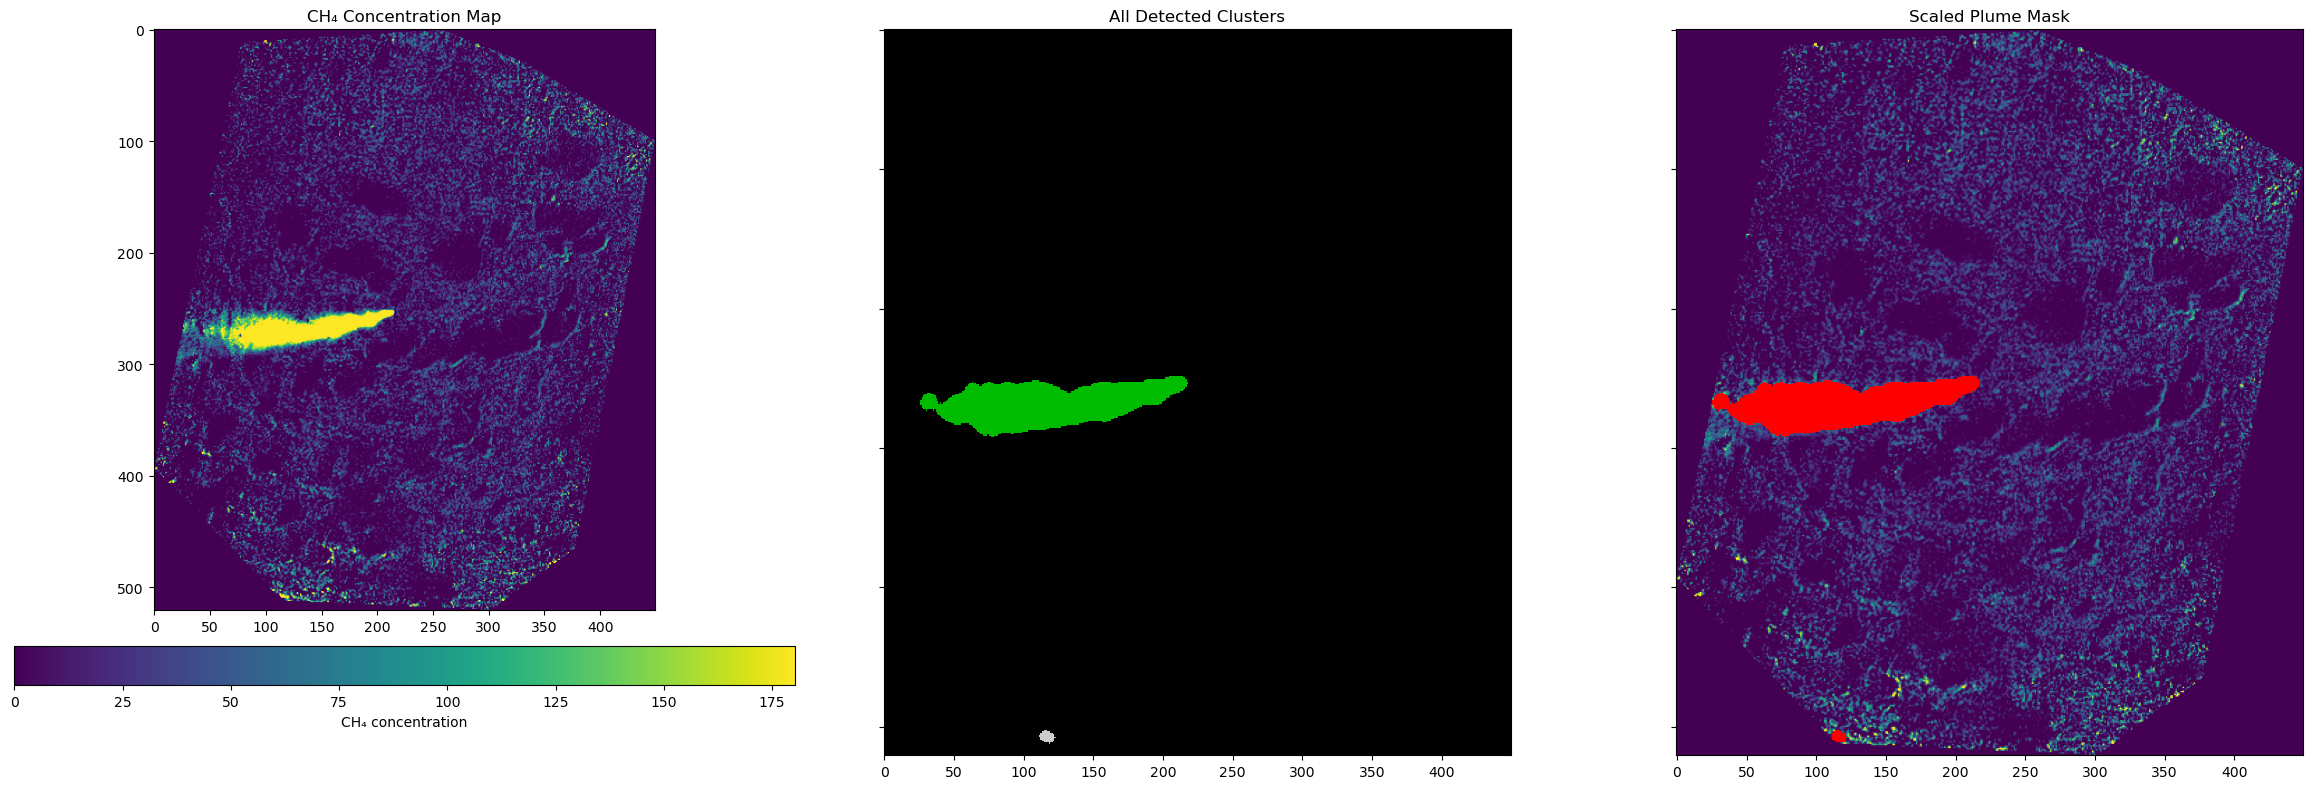

Sensor: GHGSat
Pixel size (native/used): 29.69 m / 29.69 m
Scale factor vs 30.0 m: 0.99
Scaled smoothing sigma (px): 2.02
Scaled morph radius (px): 4
Scaled min plume pixels: 21
Using sub-AOI: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/flux_exp/com_area_4segmentation.shp
Background median: 12.5742
Background std: 38.3138
Plume threshold: 50.8880
Found 2 clusters before filtering.
Kept 2 plumes after filtering.
Plume mask saved: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/C2_25044054_20240228_20250103_9iY6jsy/plume_segmentation_scaled/2025-11-26T22-57-46/C2_25044054_20240228_20250103_9iY6jsy_CH4_plume_mask_scaled.tif
Plume polygons saved: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/C2_25044054_20240228_20250103_9iY6jsy/plume_segmentation_

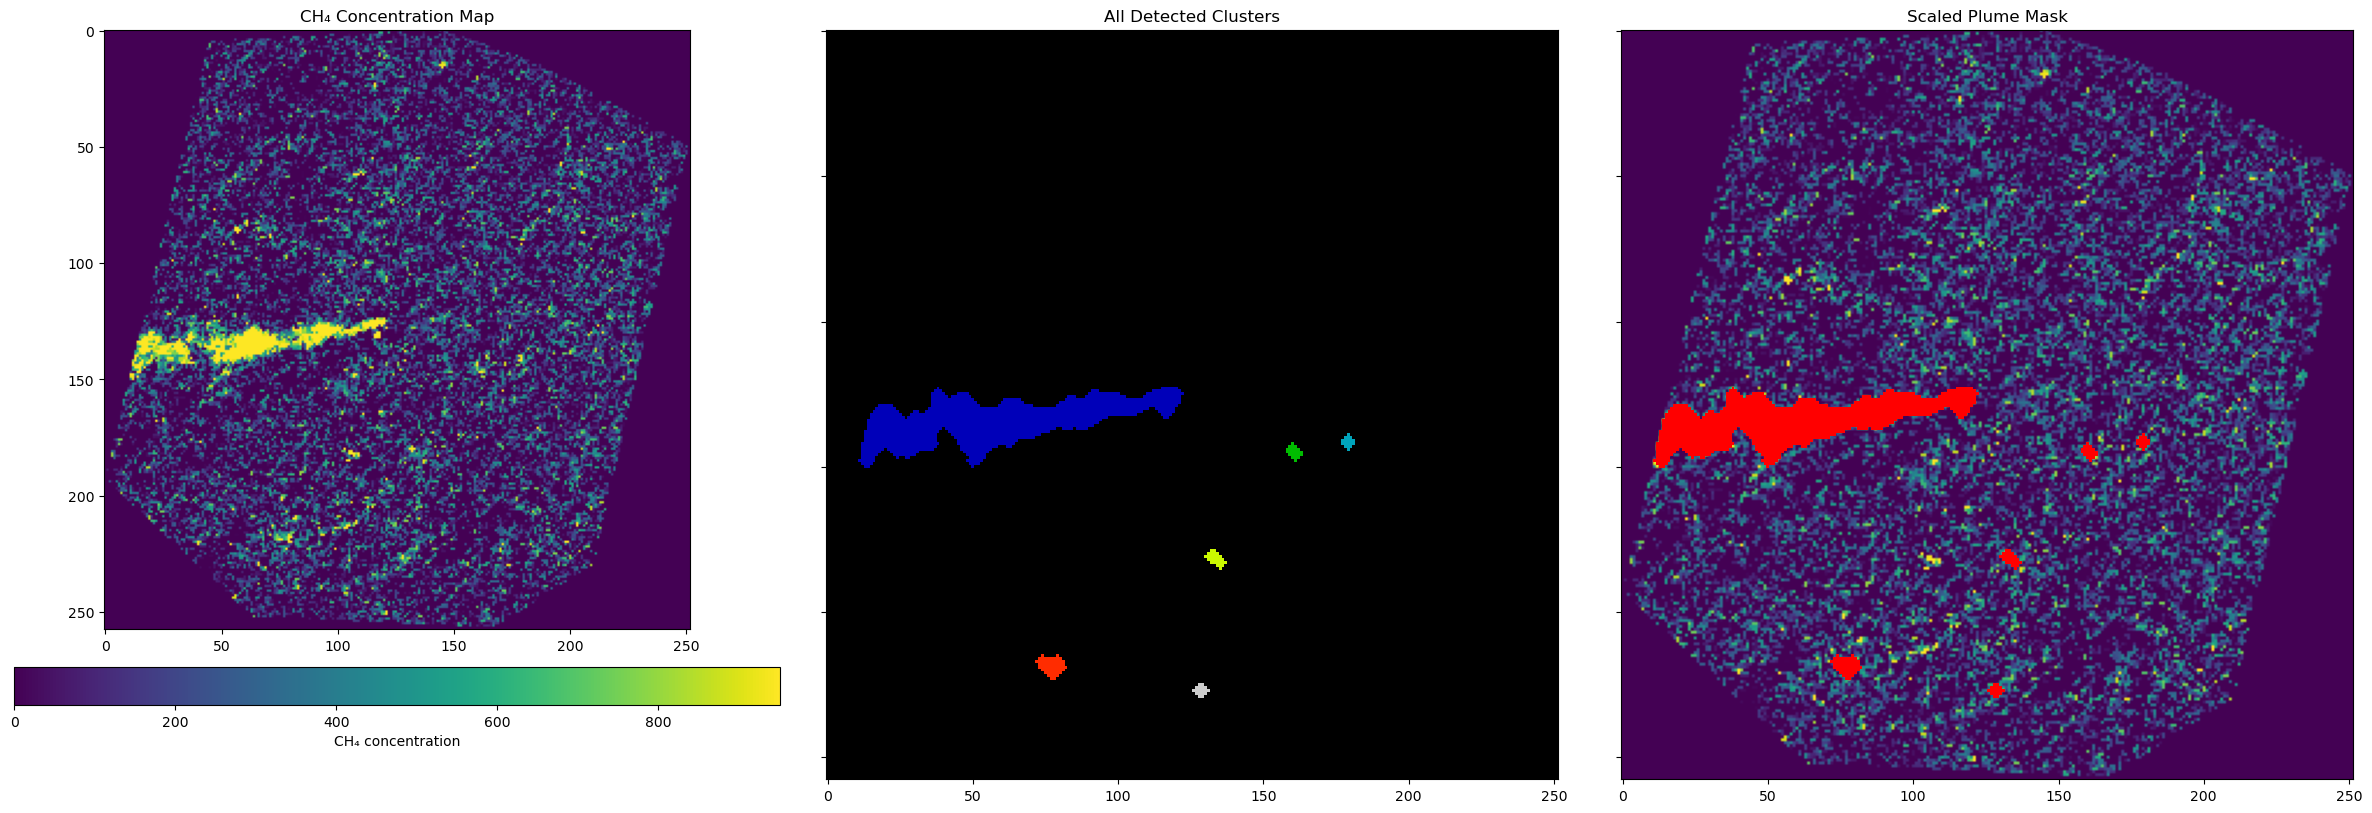

Sensor: EMIT
Pixel size (native/used): 56.90 m / 56.90 m
Scale factor vs 30.0 m: 1.90
Scaled smoothing sigma (px): 1.05
Scaled morph radius (px): 2
Scaled min plume pixels: 6
Using sub-AOI: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/flux_exp/com_area_4segmentation.shp
Background median: 109.8065
Background std: 205.7097
Plume threshold: 315.5162
Found 6 clusters before filtering.
Kept 6 plumes after filtering.
Plume mask saved: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/emit/full_dataset/EMITL2BCH4ENH_002-20251117_160414/plume_segmentation_scaled/2025-11-26T22-57-46/EMIT_L2B_CH4ENH_002_20240228T043521_2405903_003_plume_mask_scaled.tif
Plume polygons saved: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/Pakistan_20240228/emit/full_dataset/EMITL2BCH4ENH_002-2

In [28]:
results = []
for ds in DATASETS:
    res = run_plume_detection(ds)
    results.append(res)

summary_dir = PROJECT_ROOT / "logs" / "plume_segmentation_scaled"
summary_dir.mkdir(parents=True, exist_ok=True)
summary_path = summary_dir / f"Pakistan_scaled_{RUN_STAMP}.json"
summary_path.write_text(json.dumps(results, indent=2), encoding="utf-8")

print(f"\nRun summary saved to: {summary_path}")
for res in results:
    params = res["scaled_params"]
    print(
        f"{res['sensor']}: px={res['pixel_size_used_m']:.1f} m (x{res['scale_factor']:.2f}) | "
        f"smooth σ={params['smoothing_sigma_px']:.2f}px | morph r={params['morph_kernel_px']}px | "
        f"min area={params['min_plume_pixels']}px | plumes kept={res['n_plumes_kept']}/{res['total_clusters']}"
    )